In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F

In [19]:
if torch.cuda.is_available():
  dev = "cuda:0"
elif torch.backends.mps.is_available():
  dev = "mps"
else:  
  dev = "cpu"
print(dev)
device = torch.device(dev)

mps


In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = sorted(os.listdir(image_dir))
        self.mask_names = sorted(os.listdir(mask_dir))
        self.transform = transform

        # Debug print statements
        print(f"Found {len(self.image_names)} images in {image_dir}")
        if len(self.image_names) == 0:
            raise ValueError(f"No images found in {image_dir}. Please check the directory path and file extensions.")

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_names[idx])
        image = Image.open(img_name).convert('L')  # Convert to grayscale

        mask_name = os.path.join(self.mask_dir, self.mask_names[idx])
        mask = Image.open(mask_name).convert('L')  # Convert to grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Transform for normalizing and resizing
transform = transforms.Compose([
    transforms.Resize((696, 520)),  # Resize images to 696x520
    transforms.ToTensor(),  # Convert PIL image to Tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean=0.5 and std=0.5
])

# Paths to your image and mask folders
image_dir = 'Data/train/01'
mask_dir = 'Data/train/01_MASKS'

# Datasets and DataloadersD
train_dataset = CustomImageDataset(image_dir=image_dir, mask_dir=mask_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Paths to your image and mask folders for validation(using test)
val_image_dir = 'Data/test/02'
val_mask_dir = 'Data/test/02_MASKS'

# Datasets and Dataloaders for test
val_dataset = CustomImageDataset(image_dir=val_image_dir, mask_dir=val_mask_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Debug print to verify DataLoader
for images, masks in val_loader:
    print(images.shape, masks.shape)
    break  # Just to test the first batch

Found 85 images in Data/train/01
Found 84 images in Data/test/02
torch.Size([8, 1, 696, 520]) torch.Size([8, 1, 696, 520])


In [7]:
# Double convolution block with padding
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
    return conv

In [18]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(1, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)

        self.up_trans_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv_1 = double_conv(1024, 512)

        self.up_trans_2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv_2 = double_conv(512, 256)

        self.up_trans_3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv_3 = double_conv(256, 128)
        
        self.up_trans_4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv_4 = double_conv(128, 64)

        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, image):
        # Encoder
        x1 = self.down_conv_1(image)
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)

        # Decoder
        #Before each concatenation in the decoder, we check if the sizes of the tensors match. If they don't, we use nn.functional.pad to pad the smaller tensor to match the dimensions of the larger tensor.This ensures that the tensors have the same dimensions before concatenation without cropping.
        x = self.up_trans_1(x9)
        if x.size() != x7.size():
            diffY = x7.size()[2] - x.size()[2]
            diffX = x7.size()[3] - x.size()[3]
            x = nn.functional.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = self.up_conv_1(torch.cat([x, x7], 1))

        x = self.up_trans_2(x)
        if x.size() != x5.size():
            diffY = x5.size()[2] - x.size()[2]
            diffX = x5.size()[3] - x.size()[3]
            x = nn.functional.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = self.up_conv_2(torch.cat([x, x5], 1))

        x = self.up_trans_3(x)
        if x.size() != x3.size():
            diffY = x3.size()[2] - x.size()[2]
            diffX = x3.size()[3] - x.size()[3]
            x = nn.functional.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = self.up_conv_3(torch.cat([x, x3], 1))

        x = self.up_trans_4(x)
        if x.size() != x1.size():
            diffY = x1.size()[2] - x.size()[2]
            diffX = x1.size()[3] - x.size()[3]
            x = nn.functional.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = self.up_conv_4(torch.cat([x, x1], 1))

        x = self.out(x)
        return x

In [21]:
model = UNet()
# model = model.to(device)

In [22]:
# Check the model with one batch of data
# Should be [batch_size, 2, 696, 520]
for images, masks in train_loader:
    # images = images.to(device)
    outputs = model(images)
    print(f"Input shape: {images.shape}, Output shape: {outputs.shape}")
    break  # Just to test the first batch

KeyboardInterrupt: 

In [28]:
#image = torch.rand(1, 1, 696, 520)  # Batch size, channel, height, width
#model = UNet()
#output = model(image)
#print(output.size())  # Should be [1, 2, 696, 520]

showing the images in my batch

In [29]:
import matplotlib.pyplot as plt
import numpy as np
# Function to denormalize the image
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Undo normalization
    return tensor

# Visualize a batch of images and masks
def visualize_batch(dataloader):
    for images, masks in dataloader:
        # Denormalize images
        images = denormalize(images)
        
        # Convert to numpy arrays
        images = images.numpy()
        masks = masks.numpy()
        
        # Plot the images and masks
        batch_size = images.shape[0]
        plt.figure(figsize=(12, 6))
        
        for i in range(batch_size):
            # Plot image
            plt.subplot(2, batch_size, i + 1)
            plt.imshow(images[i].squeeze(), cmap='gray')
            plt.title("Image")
            plt.axis('off')

            # Plot mask
            plt.subplot(2, batch_size, i + 1 + batch_size)
            plt.imshow(masks[i].squeeze(), cmap='gray')
            plt.title("Mask")
            plt.axis('off')

        plt.show()
        break  # Just visualize the first batch


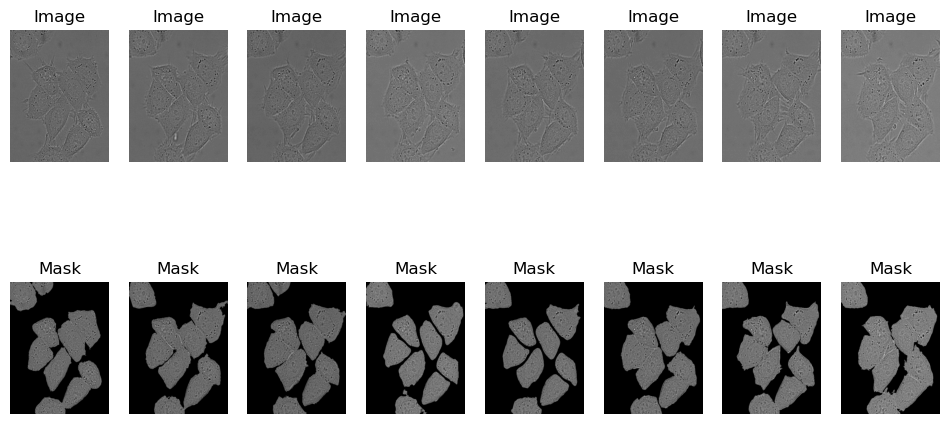

In [32]:
# Call the visualize function
visualize_batch(val_loader)

## the training and validation loop